In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scipy
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
import random
from statannot import add_stat_annotation

%matplotlib inline

# Data

Up until now, we have a CSV that has a lot of information, but first and foremost, it has the manually curated start step and stop step signifiers. Let's go ahead and import this file.

In [31]:
step_seconds = pd.read_csv('C:\\Users\\aar1105\\Box Sync\\BevanLab\\Projects\\gait\\open_field_gait\\data\\MitoPark_test_data.csv')

Let's do a little investigating. How does this look like? 

In [32]:
step_seconds.head()

,Mouse,Video,Start Time,End Time,Genotype,FPS,Include,h5
0,1057,1057-2,02:49.8,02:50.1,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...
1,1057,1057-2,02:50.1,02:50.5,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...
2,1057,1057-2,03:31.7,03:31.9,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...
3,1057,1057-2,03:31.9,03:32.2,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...
4,1057,1057-2,03:32.2,03:32.5,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...


Notably, we will mainly use the `Start Time` and `End Time` columns in our initial analyses. The other columns will come into play when we export our data. 

Cool! Now, let's move on to our video data. To start with, we'll be looking at mouse `1058`. This is a Wild Type mouse where we extracted roughly 50 steps. We have it's MitoPark counterpart to analyze right after this, but this should be a good test case, since there's more ambulation and tracking looks better. 

In [33]:
DLCscorer = "DLC_resnet152_paw_40_labelsApr2shuffle1_200000"


In [34]:
h5_file = step_seconds['h5'][0]
h5_file

'D:\\\\MitoPark\\\\Open Field\\\\DLC_MP_test\\\\1057-2-bottomDLC_resnet152_paw_40_labelsApr2shuffle1_200000.h5'

In [35]:
Dataframe = pd.read_hdf("E:\\MitoPark\\Open Field\\DLC_MP_test\\bottomDLC_resnet152_paw_40_labelsApr2shuffle1_200000.h5")

FileNotFoundError: File E:\MitoPark\Open Field\DLC_MP_test\bottomDLC_resnet152_paw_40_labelsApr2shuffle1_200000.h5 does not exist

In [36]:
Dataframe[DLCscorer].head()

NameError: name 'Dataframe' is not defined

# Paw analysis
Let's start by looking at each paw

In [37]:
start_time = '00:09.550'
end_time = '00:09.730'


In [38]:
def convert_time_to_seconds (time: str) -> int:
    
    """
    Takes time in the form MM:SS:ms and converts to seconds
    """
    time = time.split(':')
    out = int(time[0]) * 60 + float(time[1])
    return out

In [39]:
start_sec = convert_time_to_seconds(start_time)
end_sec = convert_time_to_seconds(end_time)

In [40]:
start_sec

9.55

In [41]:
np.round(end_sec - start_sec, 2)

0.18

Looks like this step was about .18 seconds in duration

In [42]:
def get_snippet(data, bodypart, DLCScorer, start_sec, end_sec, fps) -> pd.DataFrame: 
    return data[DLCscorer][bodypart][int(start_sec * fps): int(end_sec * fps)]

In [43]:
back_left = get_snippet(Dataframe, 'back-left-paw', DLCscorer, start_sec, end_sec, fps)
back_right = get_snippet(Dataframe, 'back-right-paw', DLCscorer, start_sec, end_sec, fps)


front_left = get_snippet(Dataframe, 'front-left-paw', DLCscorer, start_sec, end_sec, fps)
front_right = get_snippet(Dataframe, 'front-right-paw', DLCscorer, start_sec, end_sec, fps)

NameError: name 'Dataframe' is not defined

In [44]:
plt.plot(back_left['x'], back_left['y'], color = 'red', label = 'back left')
plt.plot(back_right['x'], back_right['y'], color = 'blue', label = 'back right')
plt.plot(front_right['x'], front_right['y'], color = 'green', label = 'front right')
plt.plot(front_left['x'], front_left['y'], color = 'black', label = 'front left')
plt.title('Single Footstep')
plt.legend()
#plt.savefig('trajectory.pdf')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.savefig('trajectory.pdf', format='pdf', dpi=1200)

plt.show()

NameError: name 'back_left' is not defined

Ok, it's claer that our front left data is a little skewed. Let's try and figure out a way to fix this. 

In [45]:
def polynomial(x, a,b,c, d):
    return a + b*x + c*x*x + d * x * x * x


def fit_paw_to_polynomial(paw):
    timedata = np.linspace(0, paw['x'].size, paw['x'].size)
    xdata = paw['x']
    ydata = paw['y']
    popt_x, pcov = curve_fit(polynomial, timedata, xdata)
    popt_y, pcov = curve_fit(polynomial, timedata, ydata)
    return polynomial(time, popt_x[0], popt_x[1], popt_x[2]), polynomial(time, popt_y[0], popt_y[1], popt_y[2])

In [46]:
time = np.arange(front_left['x'].shape[0])
np.random.seed(1729)
noise = 0.2 * np.random.normal(size=front_left['x'].size)
plt.plot(time, front_left['x'] + noise, color = 'red', label = 'front left x')

plt.plot(time, front_left['y'] + noise, color = 'green', label = 'front left y')
plt.legend()


NameError: name 'front_left' is not defined

In [47]:
timedata = np.linspace(0, 18, front_left['x'].size)
xdata = np.copy(back_right['x'])
ydata = np.copy(back_right['y'])

NameError: name 'front_left' is not defined

In [48]:
popt_x, pcov_x = curve_fit(polynomial, timedata, xdata)
popt_y, pcov_y = curve_fit(polynomial, timedata, ydata)

NameError: name 'timedata' is not defined

1) Fit polynomial 

2) Get 2 * cdf(- abs(dist/stderr)) -> Two tailed test - tells you if you're on either tail of distribution of line

3) Sample according to probabilities from 2

4) Repeat steps 1-3 until params of polynomial don't change up to some epsilon

In [49]:
def flip(p):
    return True if random.random() < p else False

def sample_and_replace(p_values, data, polynomial, timedata, popt_x):
    """
    Samples with p-values and replaces with polynomial values in place. 
    """
    to_replace = np.array(list(filter(lambda p: np.random.random() < (1 - p[1]), enumerate(p_values))))
    to_replace_idx = np.array([int(i[0]) for i in to_replace])
    data[to_replace_idx] = polynomial(timedata, *popt_x)[to_replace_idx]
    
    
def get_pvals(popt, pcov, data, polynomial, timedata):
    """
    Gets p values for every data point 
    """

    perr = np.sqrt(np.diag(pcov))
    dist = data - polynomial(timedata, *popt)

    stderr = np.std(dist)
    p_values = 2 * stats.norm.cdf(-np.abs(dist/stderr), 0, 1)
    return p_values

In [50]:
def iterate_and_fit(data, polynomial):
    timedata = np.linspace(0, data.size, data.size)
    popt_x_old, pcov_x = curve_fit(polynomial, timedata, data)
    i = 0
    while True: 
        pvals = get_pvals(popt_x_old, pcov_x, data, polynomial, timedata)
        if np.all(pvals > .025):
            break
        sample_and_replace(pvals, data, polynomial, timedata, popt_x_old)
        #plt.plot(timedata, data, label = i)
        popt_x, pcov_x = curve_fit(polynomial, timedata, data)
        if np.allclose(popt_x_old, popt_x):
            break
        else: 
            i += 1
            popt_x_old = popt_x
    #plt.legend()
    #plt.title('Iterative Regressions')
    #plt.savefig('test.png')
    #plt.show()

In [51]:
plt.plot(back_left['x'], back_left['y'], color = 'red', label = 'back left')
plt.plot(back_right['x'], back_right['y'], color = 'blue', label = 'back right')
plt.plot(front_right['x'], front_right['y'], color = 'green', label = 'front right')
plt.plot(front_left['x'], front_left['y'], color = 'black', label = 'front left')
plt.title('Single Footstep')

back_left_x = np.copy(back_left['x'])
back_left_y = np.copy(back_left['y'])
back_right_x = np.copy(back_right['x'])
back_right_y = np.copy(back_right['y'])
front_left_x = np.copy(front_left['x'])
front_left_y = np.copy(front_left['y'])
front_right_x = np.copy(front_right['x'])
front_right_y = np.copy(front_right['y'])

iterate_and_fit(back_left_x, polynomial)
iterate_and_fit(back_left_y, polynomial)
iterate_and_fit(back_right_x, polynomial)
iterate_and_fit(back_right_y, polynomial)
iterate_and_fit(front_left_x, polynomial)
iterate_and_fit(front_left_y, polynomial)
iterate_and_fit(front_right_x, polynomial)
iterate_and_fit(front_right_y, polynomial)

plt.plot(back_left_x, back_left_y, 'r--', label = 'back left resampled')
plt.plot(back_right_x, back_right_y, 'b--', label = 'back right resampled')
plt.plot(front_right_x, front_right_y, 'g--', label = 'front right resampled')
plt.plot(front_left_x, front_left_y, 'k--', label = 'front left resampled')
plt.legend()
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.savefig('single_footstep.png', format='png', dpi=1200)
plt.show()

NameError: name 'back_left' is not defined

# Metrics
Great! Now we've figured out how to detect and smooth outliers. Let's move on to metrics. 

The first metric is the time a single step takes - this is simple, we actually don't even need to look at the data for this. 

The second is the distance each paw travels during a step This is also fairly simple - euclidean distance from each point to each consecutive point. 

The third is the maximum width of a stride. 

In [52]:
from tqdm import tqdm_notebook as tqdm
import math
def convert_time_to_seconds (time: str) -> int:
    
    """
    Takes time in the form MM:SS:ms and converts to seconds
    """
    
    time = str(time)
    time = time.split(':')
    out = int(time[0]) * 60 + float(time[1])

    return out

def time_single_step(data):
    """
    Takes in our data file and returns a dictionary of data 
    """
    genotype_to_seconds = {'Genotype': [], 'Metric': []}
    for idx, row in data.iterrows():
        if row['Include']:
            start = convert_time_to_seconds(row['Start Time'])
            end = convert_time_to_seconds(row['End Time'])
            genotype_to_seconds['Genotype'].append(row['Genotype'])
            genotype_to_seconds['Metric'].append(end - start)
    return genotype_to_seconds


def displacement(x, y):
    print(np.sqrt((x[-1] - x[0])**2 +  (y[-1] - y[0])**2) * 0.0426439232409382)
    
    return np.sqrt((x[-1] - x[0])**2 +  (y[-1] - y[0])**2) * 0.0426439232409382
    
    

def get_distance_between_two(x0, x1, y0, y1):
    return np.sqrt((x1 - x0)**2 +  (y1 - y0)**2) 

def distance(x, y):
    distance = 0
    for idx in range(x.size - 1): 
        distance += get_distance_between_two(x[idx], x[idx + 1], y[idx], y[idx + 1])
    return distance * 0.0426439232409382

def data_to_metric(data, metric):
    genotype_to_distance = {'Genotype': []
                            , 'Front Left Paw': []
                            , 'Front Right Paw': []
                            , 'Back Right Paw': []
                            , 'Back Left Paw': []
                           }
    
    for idx, row in tqdm(data.iterrows()):
        if row['Include']:
            fps = row['FPS']
            start = convert_time_to_seconds(row['Start Time'])
            end = convert_time_to_seconds(row['End Time'])
            try:
                Dataframe = pd.read_hdf(row['h5'])
            except Exception as e: 
                print('ERROR')
                print(row['h5'])
            back_left = get_snippet(Dataframe, 'back-left-paw', DLCscorer, start, end, fps)
            back_right = get_snippet(Dataframe, 'back-right-paw', DLCscorer, start, end, fps)
            
            front_left = get_snippet(Dataframe, 'front-left-paw', DLCscorer, start, end, fps)
            front_right = get_snippet(Dataframe, 'front-right-paw', DLCscorer, start, end, fps)
            
            back_left_x = np.copy(back_left['x'])
            back_left_y = np.copy(back_left['y'])
            back_right_x = np.copy(back_right['x'])
            back_right_y = np.copy(back_right['y'])
            front_left_x = np.copy(front_left['x'])
            front_left_y = np.copy(front_left['y'])
            front_right_x = np.copy(front_right['x'])
            front_right_y = np.copy(front_right['y'])
            """
            BEGIN
            """
            plt.plot(back_left['x'], back_left['y'], color = 'red', label = 'back left')
            plt.plot(back_right['x'], back_right['y'], color = 'blue', label = 'back right')
            plt.plot(front_right['x'], front_right['y'], color = 'green', label = 'front right')
            plt.plot(front_left['x'], front_left['y'], color = 'black', label = 'front left')
            plt.title('Single Footstep')

            back_left_x = np.copy(back_left['x'])
            back_left_y = np.copy(back_left['y'])
            back_right_x = np.copy(back_right['x'])
            back_right_y = np.copy(back_right['y'])
            front_left_x = np.copy(front_left['x'])
            front_left_y = np.copy(front_left['y'])
            front_right_x = np.copy(front_right['x'])
            front_right_y = np.copy(front_right['y'])

            iterate_and_fit(back_left_x, polynomial)
            iterate_and_fit(back_left_y, polynomial)
            iterate_and_fit(back_right_x, polynomial)
            iterate_and_fit(back_right_y, polynomial)
            iterate_and_fit(front_left_x, polynomial)
            iterate_and_fit(front_left_y, polynomial)
            iterate_and_fit(front_right_x, polynomial)
            iterate_and_fit(front_right_y, polynomial)

            plt.plot(back_left_x, back_left_y, 'r--', label = 'back left resampled')
            plt.plot(back_right_x, back_right_y, 'b--', label = 'back right resampled')
            plt.plot(front_right_x, front_right_y, 'g--', label = 'front right resampled')
            plt.plot(front_left_x, front_left_y, 'k--', label = 'front left resampled')
            plt.legend()
            plt.xlabel('X (pixels)')
            plt.ylabel('Y (pixels)')
            plt.show()
            """
            END
            """
            try:
                iterate_and_fit(back_left_x, polynomial)
            except Exception as e: 
                print(start, end, row['h5'])
                continue
            iterate_and_fit(back_left_y, polynomial)
            iterate_and_fit(back_right_x, polynomial)
            
            iterate_and_fit(back_right_y, polynomial)
            iterate_and_fit(front_left_x, polynomial)
            iterate_and_fit(front_left_y, polynomial)
            iterate_and_fit(front_right_x, polynomial)
            iterate_and_fit(front_right_y, polynomial)

            genotype_to_distance['Genotype'].append(row['Genotype'])
            genotype_to_distance['Front Left Paw'].append(metric(front_left_x, front_left_y))
            genotype_to_distance['Front Right Paw'].append(metric(front_right_x, front_right_y))
            genotype_to_distance['Back Left Paw'].append(metric(back_left_x, back_left_y))
            genotype_to_distance['Back Right Paw'].append(metric(back_right_x, back_right_y))
    return genotype_to_distance

C:\Users\aar1105\.conda\envs\notebook\lib\site-packages\ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

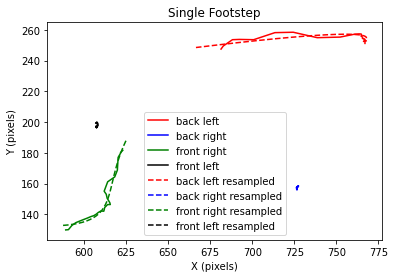

0.10647024858824015
2.845294704309489
4.366110518920536
0.08167069940666705


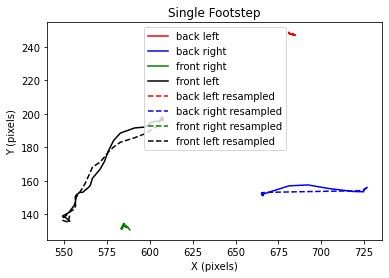

3.335570700038901
0.15271917320273629
0.08480332596371525
2.5973606748156355


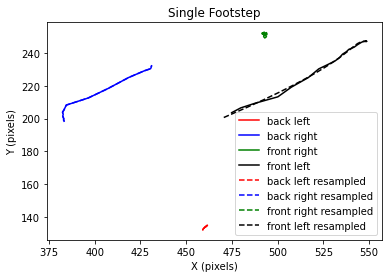

3.8747908398219835
0.06301290530199306
0.1591408606356189
2.4956668283965784


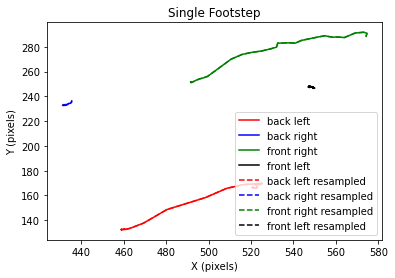

0.01867178252104704
3.855546869290566
3.040588317197374
0.1957505656166183


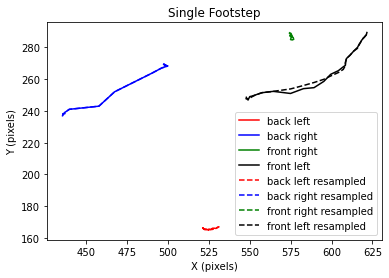

3.5874475847845115
0.07754035622109043
0.42543527967094896
2.9882049376733546


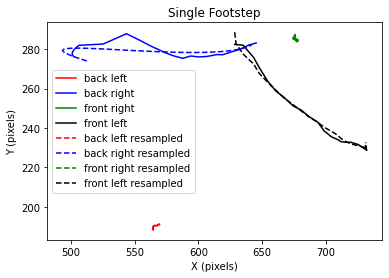

4.986174391742887
0.20053425290679644
0.24050094635495797
5.5326005519688035


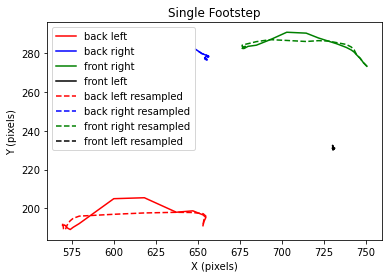

0.08398000824040222
3.110425090203669
3.5560077364781377
0.3078334381662065


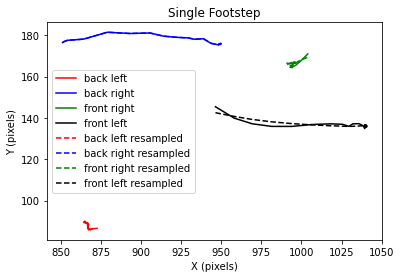

4.017950331565674
0.571004326633167
0.2939244579559977
4.159097942879082


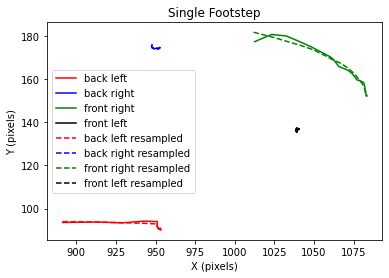

0.051663349537854474
3.2905343866292993
2.6392347480742613
0.22788616275713516


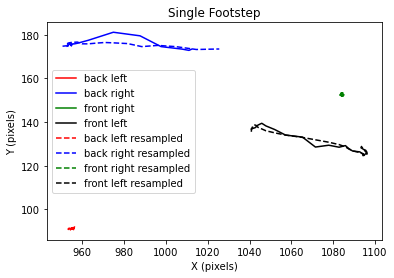

2.255209693260404
0.04576254463639704
0.1262219841592029
3.1971441929464244


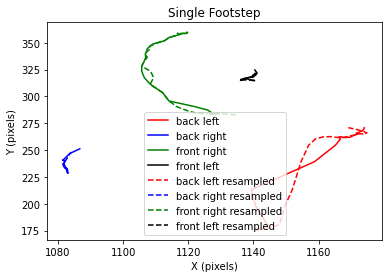

0.3319930918952218
3.341959903321412
4.219310985168297
0.8257578140571229


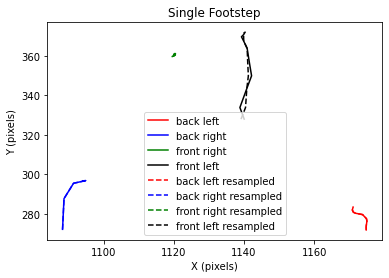

1.8791930205320793
0.05436564128265008
0.5188645925903906
1.0776539475741571


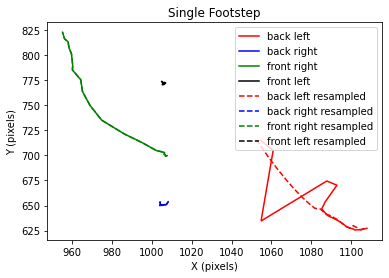

0.07137186640234092
5.705082683874171
4.399302760056863
0.16851945574470298


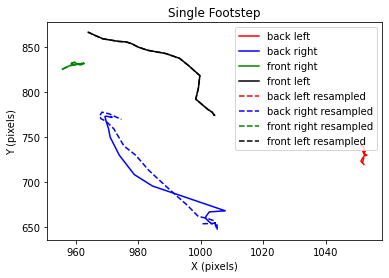

4.306519201992464
0.3189104862531924
0.8688691637220789
5.077308466175915


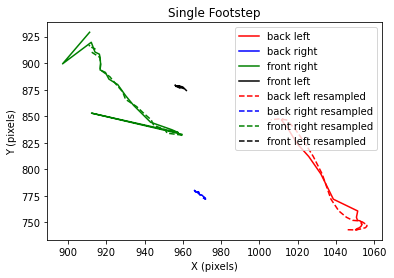

0.24829037432092602
4.130575791385432
4.733915709459895
0.3672376402994126


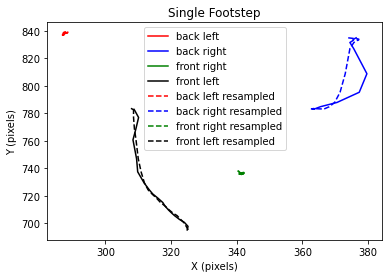

3.8224688716387494
0.08715710514362696
0.02109663218136823
2.237113349545853


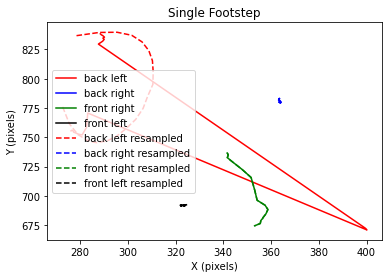

0.11155300216751612
2.6942699964954784
2.5926177169945124
0.1538421172437226


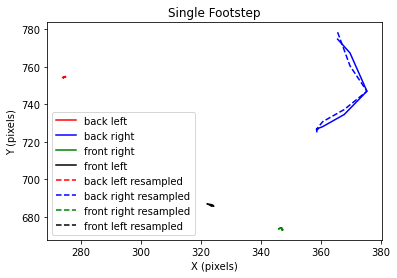

0.0447406820611861
0.06253056300030171
0.03528647850213578
2.230813854658648


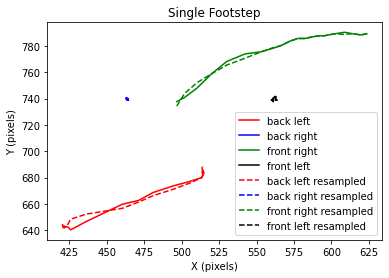

0.08874432378862618
5.902296601703757
4.275920710750502
0.08121359291252507


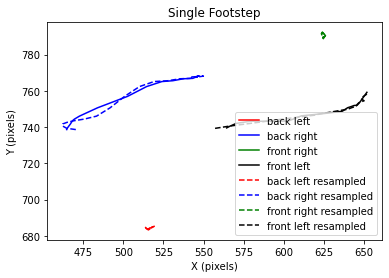

4.110164754057115
0.07500523141696669
0.22470425067188193
3.3064221080116947


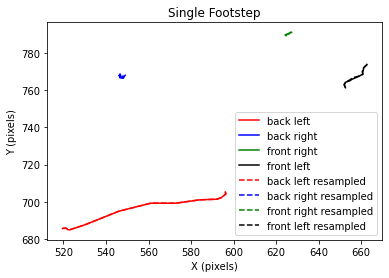

0.6865764998703134
0.12935226909945438
3.369147650589503
0.11810282217547334


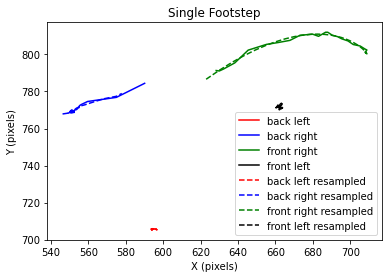

0.07985211138777087
3.671502041376046
0.09608992904014375
1.4305988852459681


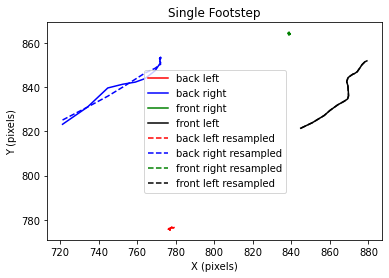

1.9571536418968951
0.024358168641601993
0.1236634344070979
2.4658530871939273


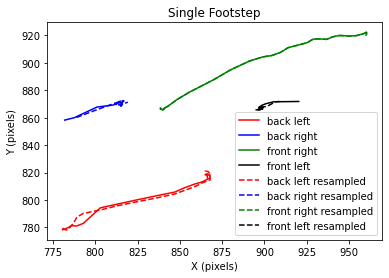

0.6568747603725864
5.670333556996009
3.9558546964530454
1.3748334302476404


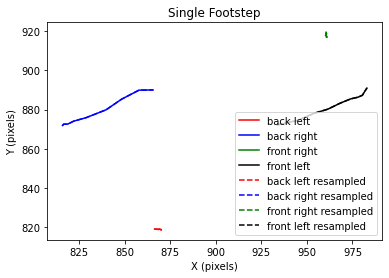

2.243759568777374
0.11058374660122638
0.15676371062090427
2.254758227472521


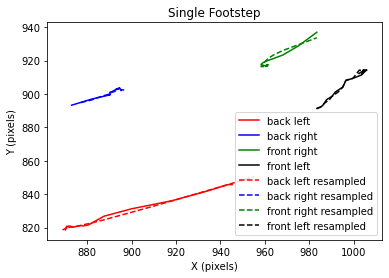

1.1940525023277258
1.2081126827463473
3.914538459473374
0.8920617698896878


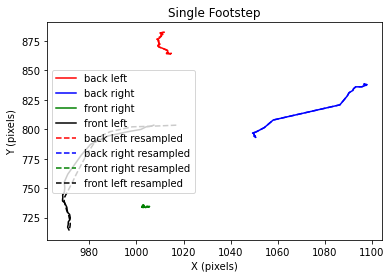

4.262884975110496
0.1125058967758872
0.8014745246291382
2.74432059576035


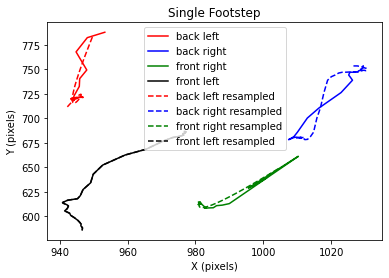

4.474478858640762
1.8727292506405155
3.085172422374893
3.176795598461754


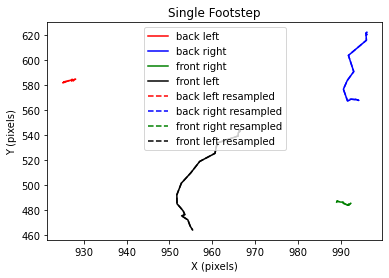

3.4764391539397503
0.14524039310022643
0.12471142176156517
2.321905459132659


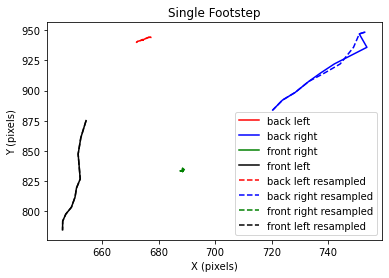

3.875771712933344
0.014923521753340175
0.27401440096929247
3.0789187462661882


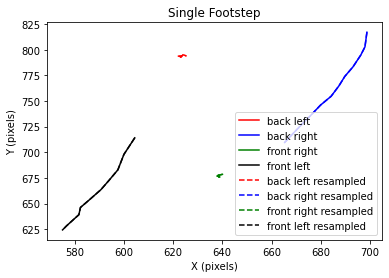

4.025571992152115
0.12055167397548448
0.12451269067231001
4.800208733325602


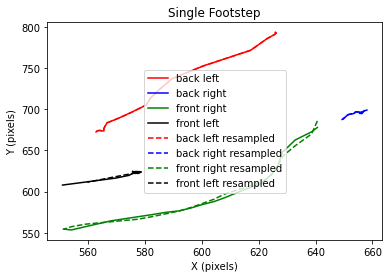

0.9088847227987192
6.776597237530726
5.812915410210901
0.5898134657242387


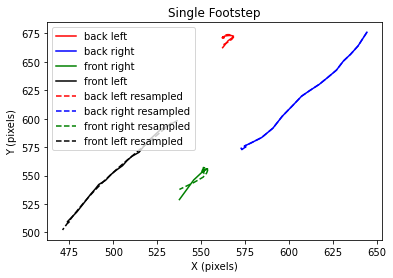

4.813463095856439
0.9631551654500714
0.33969383481966403
5.318009568821836


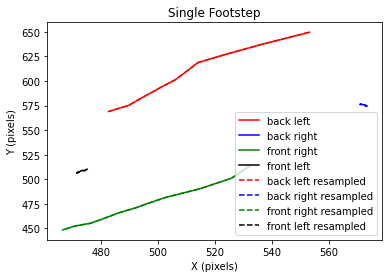

0.19682174669684802
3.9392293473320312
4.570624842965149
0.1110801335938247


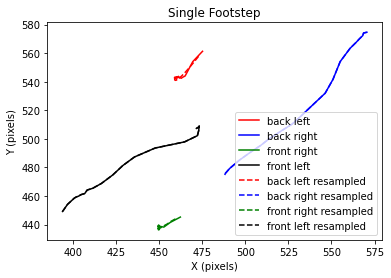

4.13721894592176
0.4863483731639453
0.8742206068675247
5.507092632888143


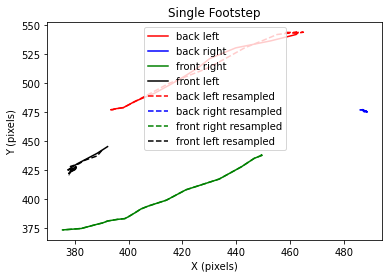

1.0555446062931422
4.190942992086587
3.9528173120512737
0.12800788116684608


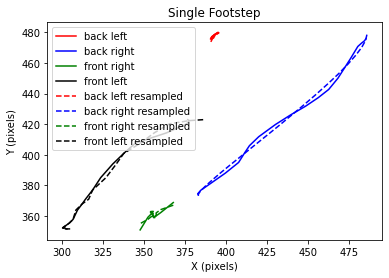

4.606592328276934
1.0030762820698222
0.13828993555128666
6.276056550916126


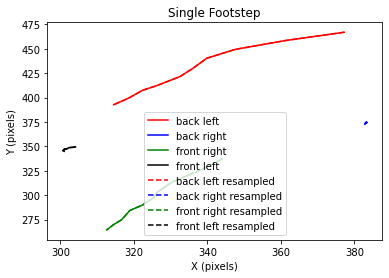

0.23409272380879842
3.379008005713983
4.147555731130907
0.05786092780296468


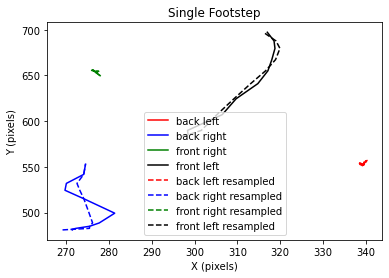

4.9070642753375635
0.18667680188273478
0.18446720430957933
3.074518181263208


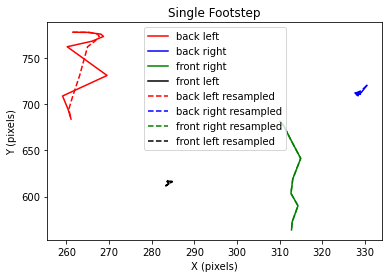

0.1097771661653979
5.026164890370201
4.0161003514794835
0.5024544459552333


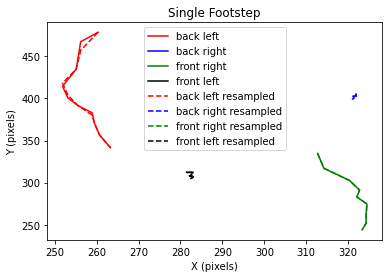

0.32854808243101313
3.903734765702138
5.853056644567316
0.2486039315415811


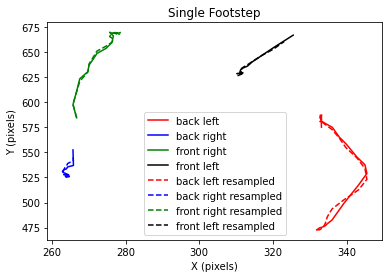

1.5475398789598165
3.5815948841760443
4.265650975247236
0.8089352513439845


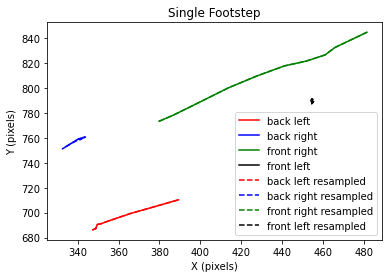

0.06261676099996255
5.2955072643233745
2.0625151946896034
0.5459214046985379


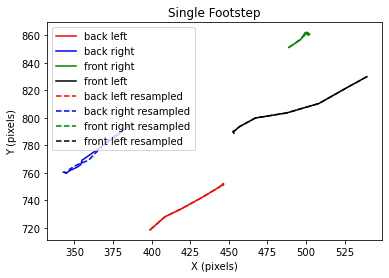

4.067406727712286
0.7123795357258804
2.4644425581230487
2.41076065887029


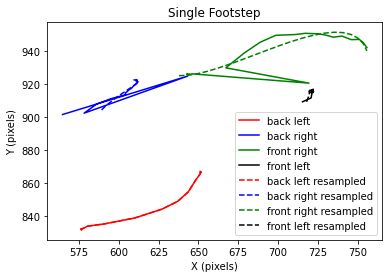

0.2665342380369957
5.07677918944545
3.519674326722348
1.1555689677557246


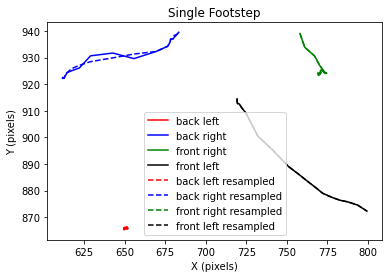

3.8588089236796312
0.8352341108625458
0.05056880138899697
3.145675551645003


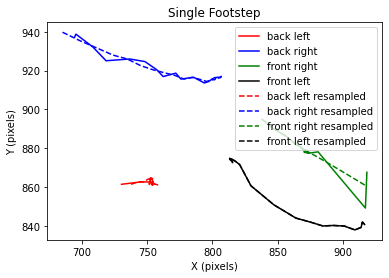

4.528878530035128
3.7069932027454997
0.8616774779126474
5.279022725975222


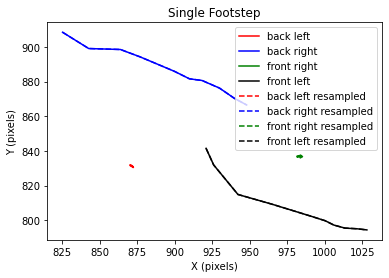

4.991466544056135
0.09309433973958806
0.04774993101717893
5.5295456043893045


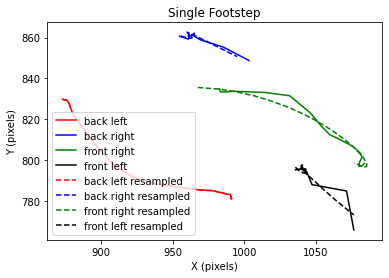

2.004647687452037
4.930610210666252
5.445672180171853
1.7329256087814986


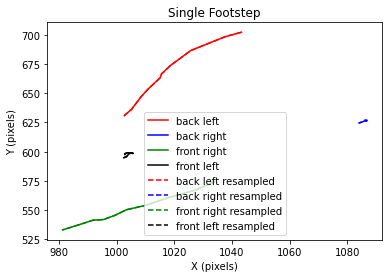

0.11773632411604336
2.869201645692067
3.498683542865316
0.1390776769952896


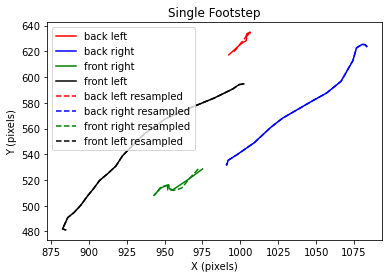

6.96514225090127
1.5070861566177929
0.6344548648187136
5.56909498351446


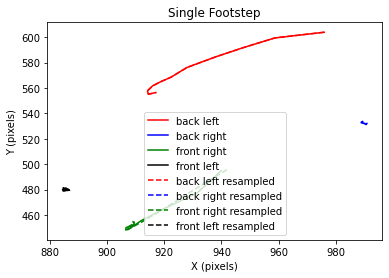

0.09576476757361368
2.2434576368189427
3.2307982349311213
0.08918086167765146


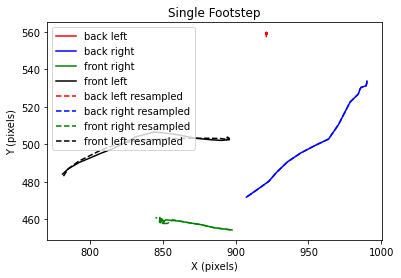

4.9081685274690345
2.2242037688737275
0.05759791121601457
4.40740434815771


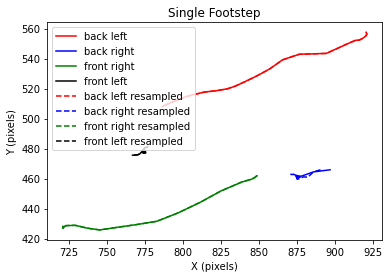

0.4861356642448232
5.63705784729485
6.098765714471069
0.8587848460952007


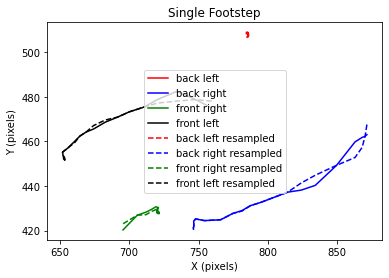

4.688599540633196
1.1060811354719196
0.04439736400260096
5.697300310054357


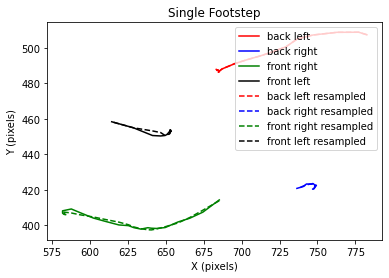

1.65121015507458
4.33646699204487
4.319375769174628
0.4058333802386061


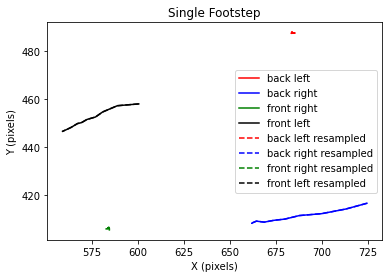

1.8326660834691502
0.07592870680434714
0.00889082092598151
2.6920362543782095


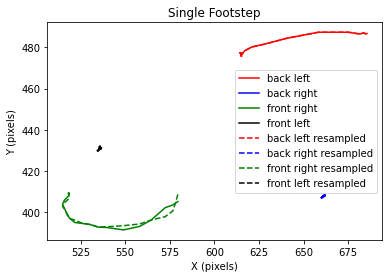

0.12007425595934837
2.618159397711496
3.0328173804302807
0.015004752910513761


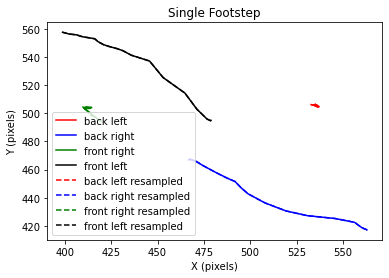

4.335775631402524
0.4248269420732434
0.1322387456372134
4.617960096297077


In [53]:
displacement_dict = data_to_metric(step_seconds, displacement)

C:\Users\aar1105\.conda\envs\notebook\lib\site-packages\ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

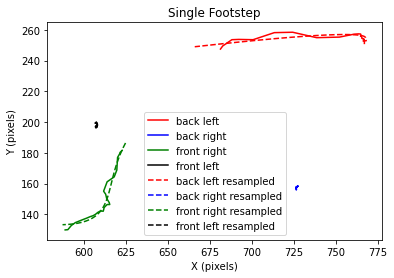

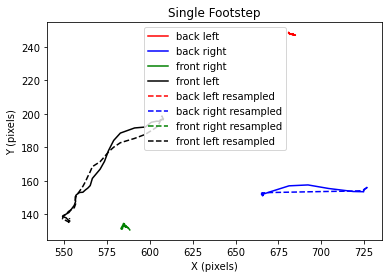

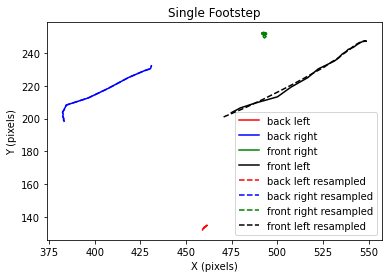

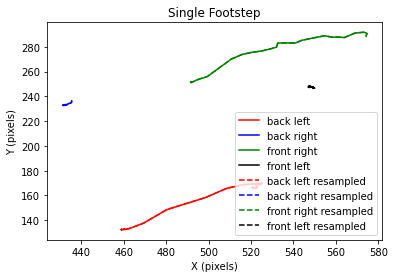

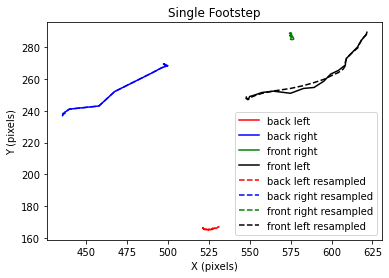

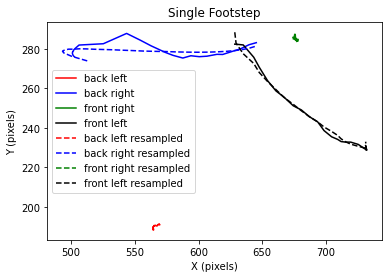

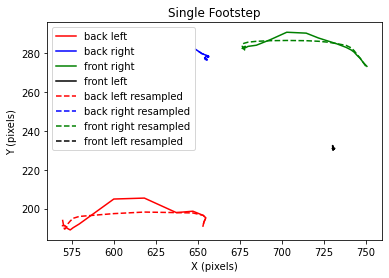

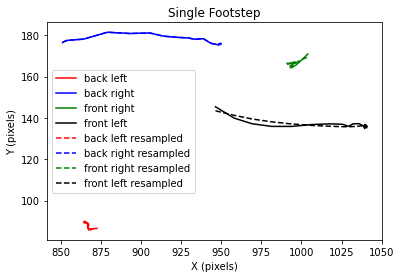

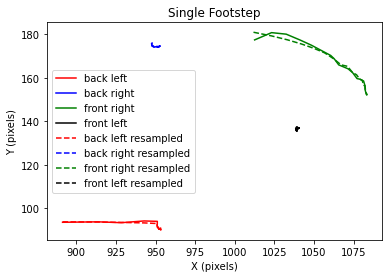

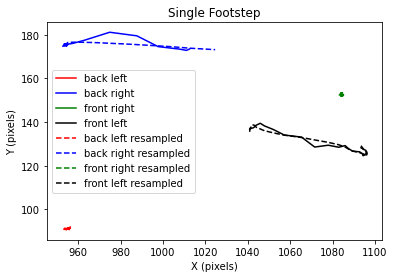

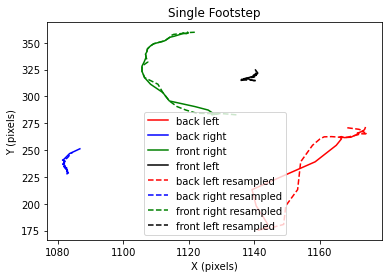

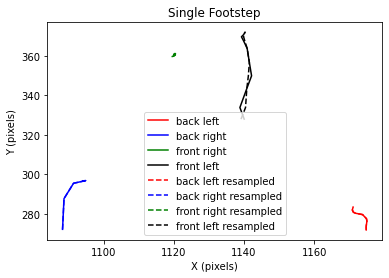

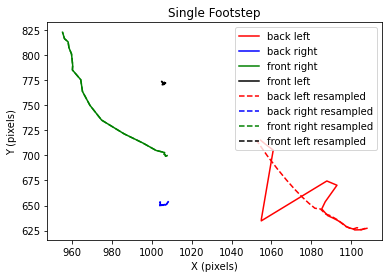

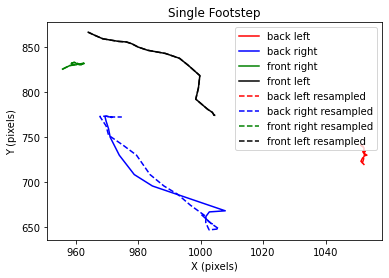

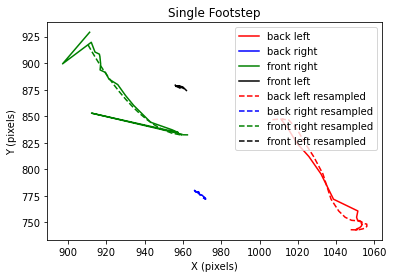

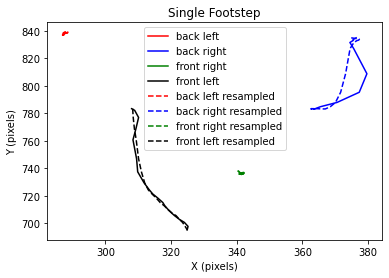

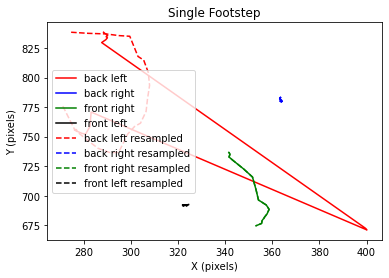

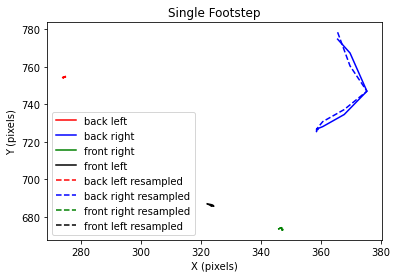

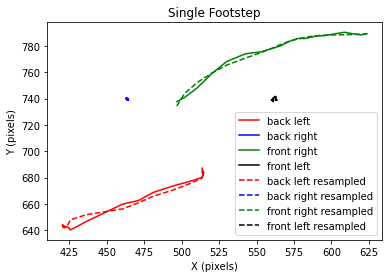

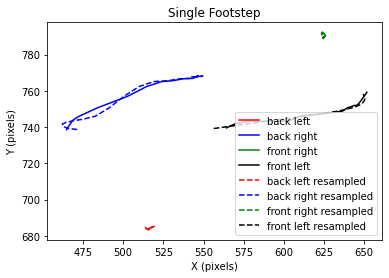

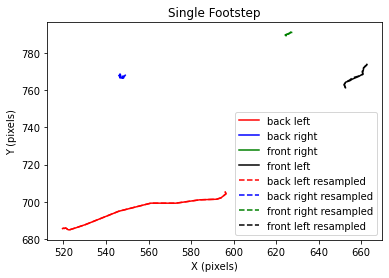

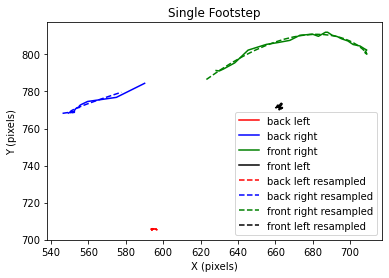

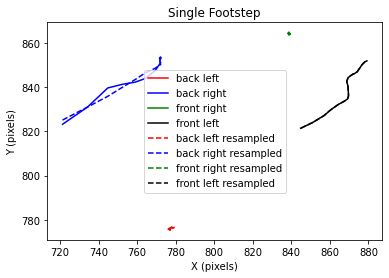

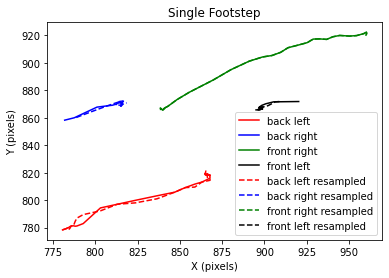

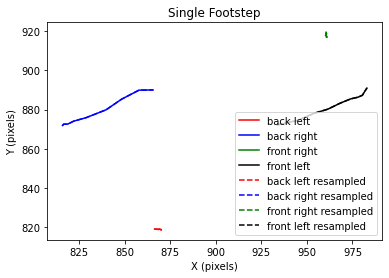

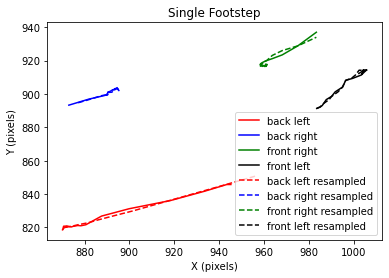

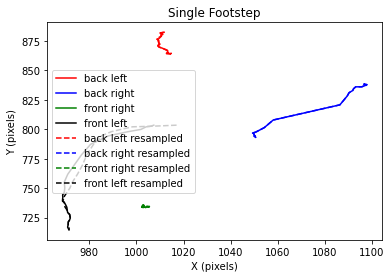

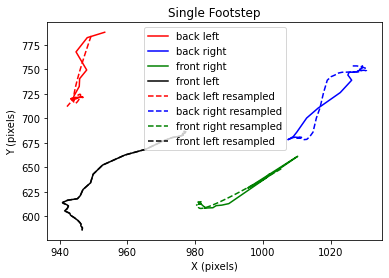

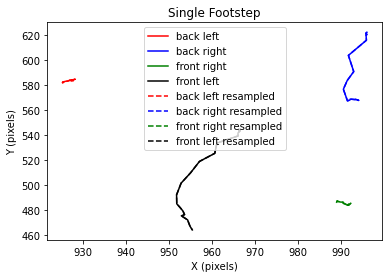

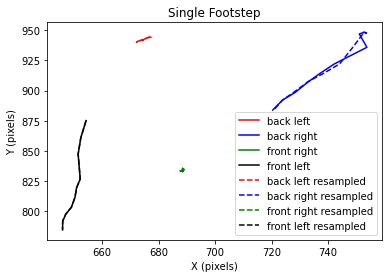

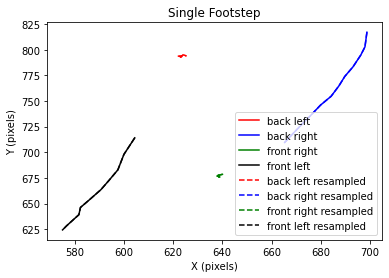

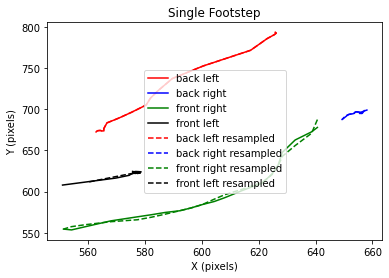

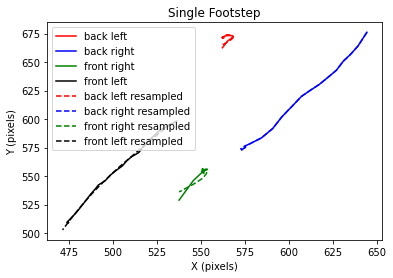

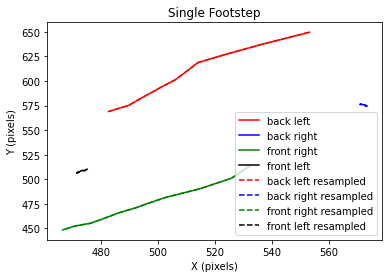

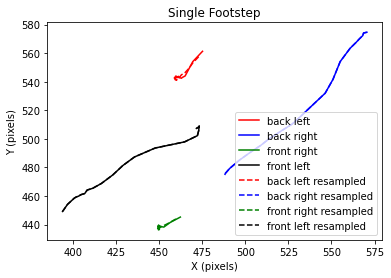

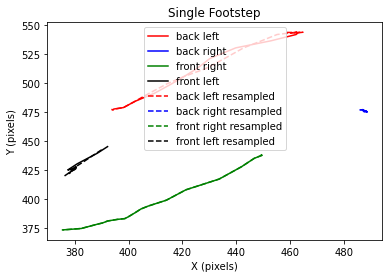

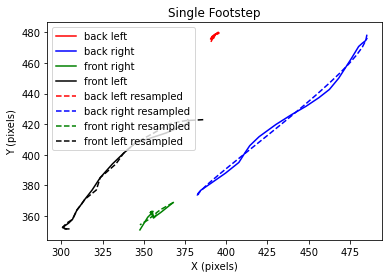

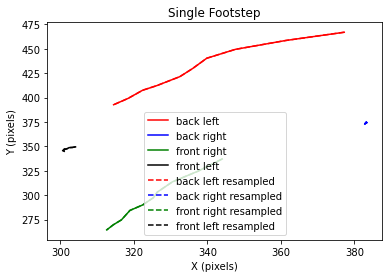

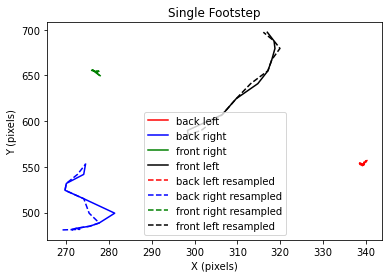

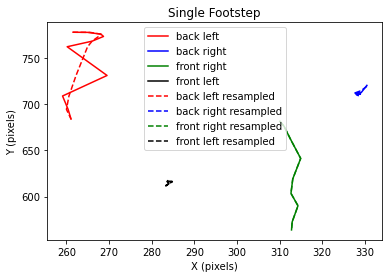

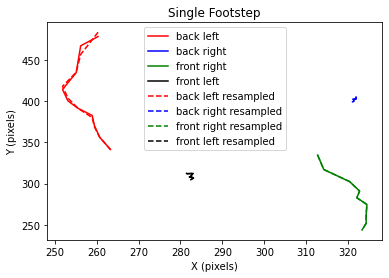

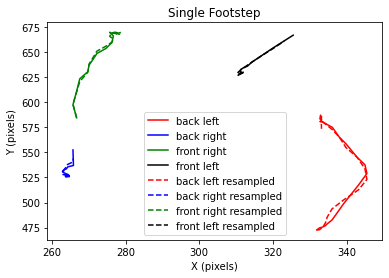

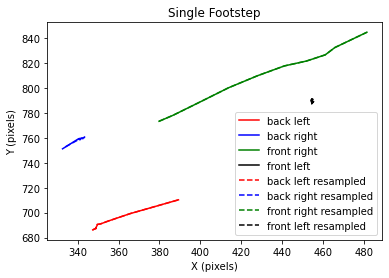

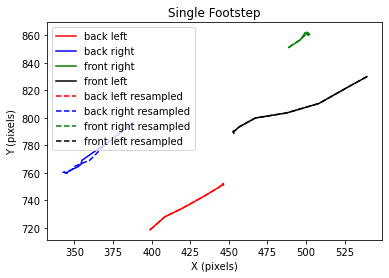

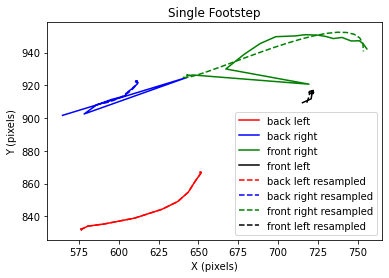

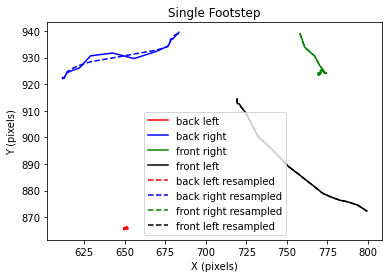

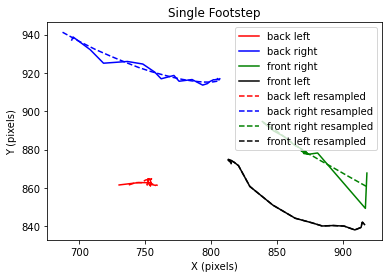

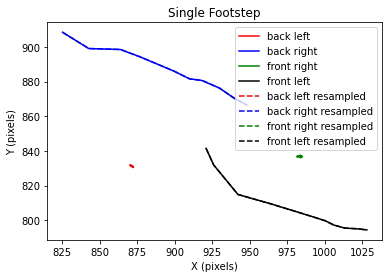

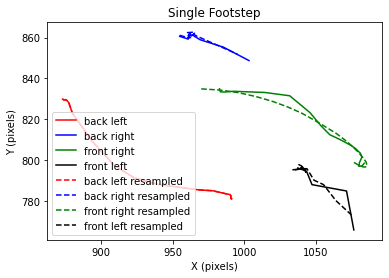

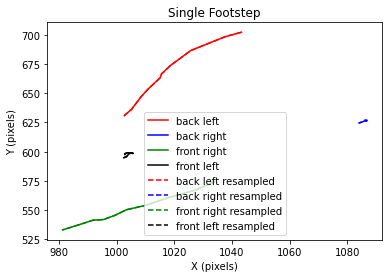

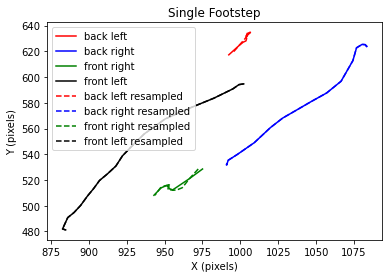

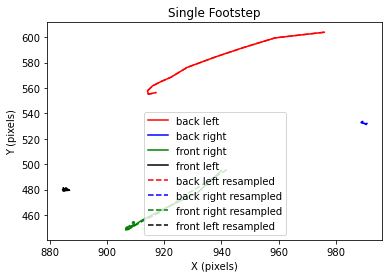

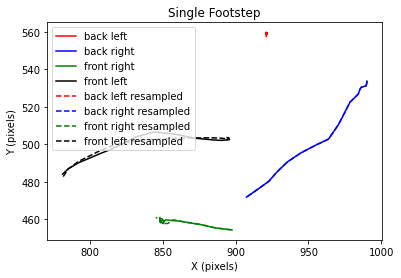

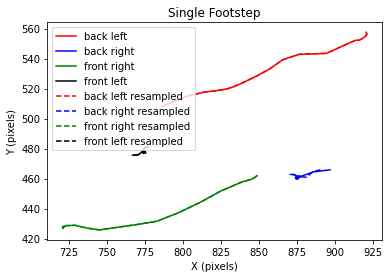

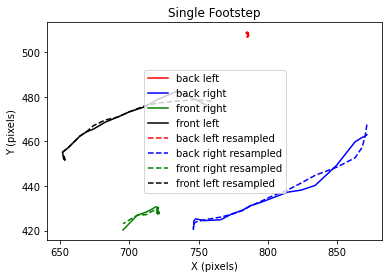

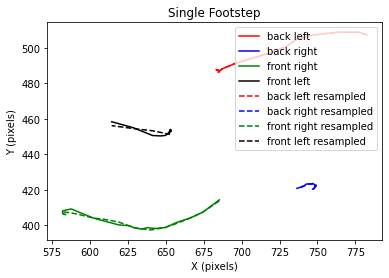

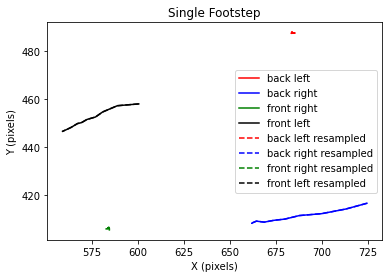

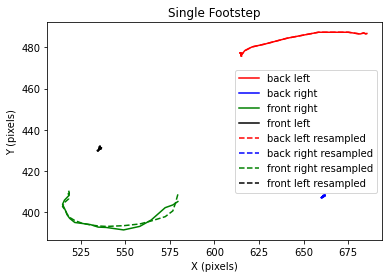

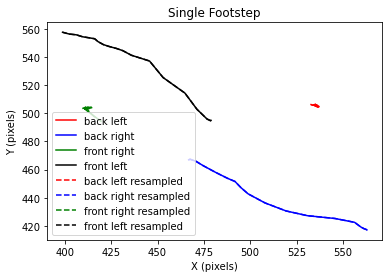

In [54]:
distance_dict = data_to_metric(step_seconds, distance)

MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.296e-02 U_stat=3.010e+02
MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.131e-01 U_stat=3.300e+02
MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.439e-01 U_stat=3.840e+02
MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.808e-01 U_stat=3.880e+02


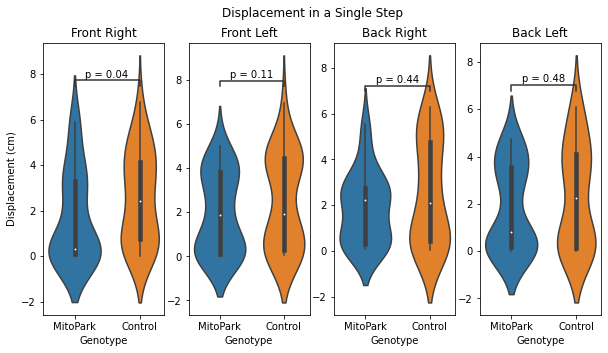

In [74]:
dic = {'Genotype': displacement_dict['Genotype'], 'Metric': displacement_dict['Front Right Paw']} 
df = pd.DataFrame.from_dict(dic)
fig,axes = plt.subplots(1,4,figsize=(10,5))
order = ['MitoPark', 'Control']
sns.violinplot(x = "Genotype", y = "Metric",ax = axes[0], data =df)
add_stat_annotation(axes[0], data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
axes[0].set_title('Front Right')
axes[1].set_title('Front Left')
axes[2].set_title('Back Right')
axes[3].set_title('Back Left')

axes[0].set_ylabel('Displacement (cm)')
axes[1].set_ylabel('Displacement (cm)')
axes[2].set_ylabel('Displacement (cm)')
axes[3].set_ylabel('Displacement (cm)')
df.to_csv('front-right-displacement.csv')

dic = {'Genotype': displacement_dict['Genotype'], 'Metric': displacement_dict['Front Left Paw']} 

df = pd.DataFrame.from_dict(dic)

v1 = sns.violinplot(x = "Genotype", y = "Metric",ax = axes[1], data =df)
v1.set(ylabel = None)
add_stat_annotation(axes[1], data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
df.to_csv('front-left-displacement.csv')


dic = {'Genotype': displacement_dict['Genotype'], 'Metric': displacement_dict['Back Right Paw']} 
df = pd.DataFrame.from_dict(dic)

v2 = sns.violinplot(x = "Genotype", y = "Metric",ax = axes[2], data =df)
v2.set(ylabel = None)

add_stat_annotation(axes[2], data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
df.to_csv('back-right-displacement.csv')

dic = {'Genotype': displacement_dict['Genotype'], 'Metric': displacement_dict['Back Left Paw']} 
df = pd.DataFrame.from_dict(dic)

v3 = sns.violinplot(x = "Genotype", y = "Metric",ax = axes[3], data =df)
v3.set(ylabel = None)

add_stat_annotation(axes[3], data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
plt.suptitle('Displacement in a Single Step')

df.to_csv('back-left-displacement.csv')
plt.savefig('displacement_along_single_step.pdf')
plt.show()

MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.114e-02 U_stat=3.110e+02
MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.400e-01 U_stat=3.570e+02
MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.438e-01 U_stat=4.040e+02
MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.920e-01 U_stat=3.650e+02


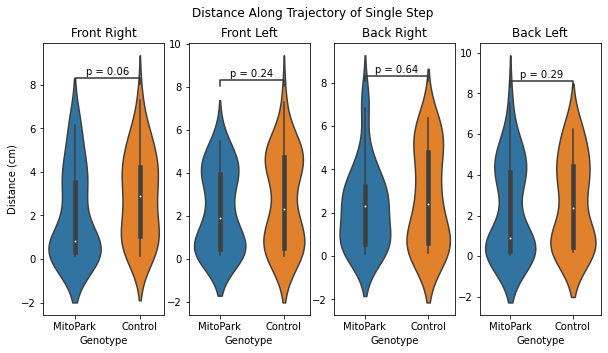

In [73]:
dic = {'Genotype': distance_dict['Genotype'], 'Metric': distance_dict['Front Right Paw']} 
df = pd.DataFrame.from_dict(dic)
fig,axes = plt.subplots(1,4,figsize=(10,5))
order = ['MitoPark', 'Control']
sns.violinplot(x = "Genotype", y = "Metric",ax = axes[0], data =df)
add_stat_annotation(axes[0], data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
axes[0].set_title('Front Right')
axes[1].set_title('Front Left')
axes[2].set_title('Back Right')
axes[3].set_title('Back Left')

axes[0].set_ylabel('Distance (cm)')
axes[1].set_ylabel('Distance (cm)')
axes[2].set_ylabel('Distance (cm)')
axes[3].set_ylabel('Distance (cm)')
df.to_csv('front-right-distance.csv')

dic = {'Genotype': distance_dict['Genotype'], 'Metric': distance_dict['Front Left Paw']} 

df = pd.DataFrame.from_dict(dic)

v1 = sns.violinplot(x = "Genotype", y = "Metric",ax = axes[1], data =df)
v1.set(ylabel = None)
add_stat_annotation(axes[1], data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
df.to_csv('front-left-distance.csv')


dic = {'Genotype': distance_dict['Genotype'], 'Metric': distance_dict['Back Right Paw']} 
df = pd.DataFrame.from_dict(dic)

v2 = sns.violinplot(x = "Genotype", y = "Metric",ax = axes[2], data =df)
v2.set(ylabel = None)

add_stat_annotation(axes[2], data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
df.to_csv('back-right-distance.csv')

dic = {'Genotype': distance_dict['Genotype'], 'Metric': distance_dict['Back Left Paw']} 
df = pd.DataFrame.from_dict(dic)

v3 = sns.violinplot(x = "Genotype", y = "Metric",ax = axes[3], data =df)
v3.set(ylabel = None)

add_stat_annotation(axes[3], data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
plt.suptitle('Distance Along Trajectory of Single Step')
df.to_csv('back-left-distance.csv')
plt.savefig('distance_along_traj.pdf')
plt.show()

MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.166e-01 U_stat=3.310e+02


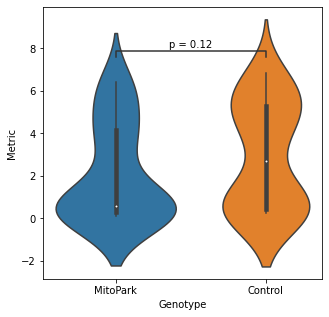

MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.166e-01 U_stat=3.310e+02


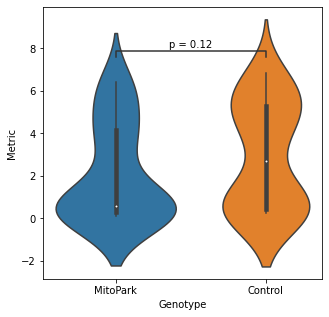

MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.133e-01 U_stat=3.680e+02


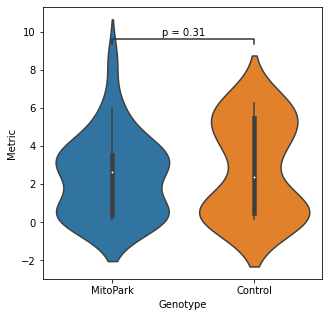

MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.670e-01 U_stat=3.750e+02


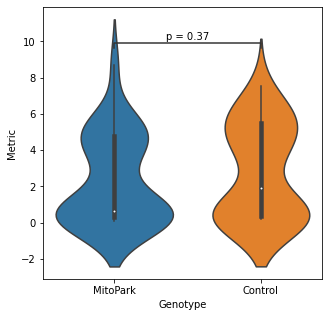

In [46]:
dic = {'Genotype': displacement_dict['Genotype'], 'Metric': displacement_dict['Front Right Paw']} 
df = pd.DataFrame.from_dict(dic)
fig,ax = plt.subplots(1,figsize=(5,5))

sns.violinplot(x = "Genotype", y = "Metric",ax = ax, data =df)
add_stat_annotation(ax, data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
plt.show()
df.to_csv('front-right-distance.csv')

dic = {'Genotype': displacement_dict['Genotype'], 'Metric': displacement_dict['Front Left Paw']} 
fig,ax = plt.subplots(1,figsize=(5,5))

sns.violinplot(x = "Genotype", y = "Metric",ax = ax, data =df)
add_stat_annotation(ax, data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
plt.show()
df.to_csv('front-left-distance.csv')


dic = {'Genotype': displacement_dict['Genotype'], 'Metric': displacement_dict['Back Right Paw']} 
df = pd.DataFrame.from_dict(dic)
fig,ax = plt.subplots(1,figsize=(5,5))

sns.violinplot(x = "Genotype", y = "Metric",ax = ax, data =df)
add_stat_annotation(ax, data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
plt.show()
df.to_csv('back-right-distance.csv')

dic = {'Genotype': displacement_dict['Genotype'], 'Metric': displacement_dict['Back Left Paw']} 
df = pd.DataFrame.from_dict(dic)
fig,ax = plt.subplots(1,figsize=(5,5))

sns.violinplot(x = "Genotype", y = "Metric",ax = ax, data =df)
add_stat_annotation(ax, data=df, x = "Genotype", y = "Metric", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
plt.show()
df.to_csv('back-left-distance.csv')

In [112]:
df.to_csv('front-right-displacement.csv')

MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.550e-06 U_stat=7.375e+02


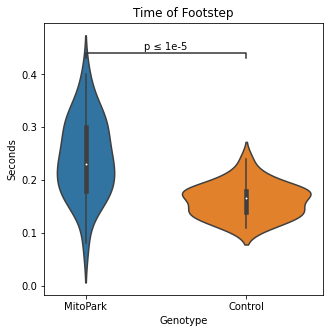

In [17]:
df = time_single_step(step_seconds)
df = pd.DataFrame.from_dict(df)
order = ['MitoPark', 'Control']
x = 'Genotype'
y = 'Metric'
fig,ax = plt.subplots(1,figsize=(5,5))

sns.violinplot(x = x, y = y, ax = ax, data = df)
add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
plt.ylabel('Seconds')
plt.title('Time of Footstep')
plt.savefig('mitopark_test_seconds_violin.pdf')




In [15]:
help(add_stat_annotation)

Help on function add_stat_annotation in module statannot.statannot:

add_stat_annotation(ax, plot='boxplot', data=None, x=None, y=None, hue=None, units=None, order=None, hue_order=None, box_pairs=None, width=0.8, perform_stat_test=True, pvalues=None, test_short_name=None, test=None, text_format='star', pvalue_format_string=<object object at 0x0000024ECF9F3AC0>, text_annot_custom=None, loc='inside', show_test_name=True, pvalue_thresholds=<object object at 0x0000024ECF9F3AC0>, stats_params={}, comparisons_correction='bonferroni', use_fixed_offset=False, line_offset_to_box=None, line_offset=None, line_height=0.02, text_offset=1, color='0.2', linewidth=1.5, fontsize='medium', verbose=1)
    Optionally computes statistical test between pairs of data series, and add statistical annotation on top
    of the boxes/bars. The same exact arguments `data`, `x`, `y`, `hue`, `order`, `width`,
    `hue_order` (and `units`) as in the seaborn boxplot/barplot function must be passed to this function.
  

In [114]:
plt.plot(xdata, ydata)

NameError: name 'xdata' is not defined

In [ ]:
plt.plot(xdata, ydata)

In [ ]:
popt_x, pcov_x = curve_fit(polynomial, timedata, xdata)
plt.plot(timedata, polynomial(timedata, *popt_x), label = 'init')
for i in range(10):
    perr = np.sqrt(np.diag(pcov_x))
    dist = xdata - polynomial(timedata, *popt_x)
    
    stderr = dist/np.std(dist)
    try:
        popt_x, pcov_x = curve_fit(polynomial, timedata, xdata, sigma = stderr)
        plt.plot(timedata, polynomial(timedata, *popt_x), label = i)
    except Exception as e:
        print(stderr)
        
plt.legend()
plt.show()

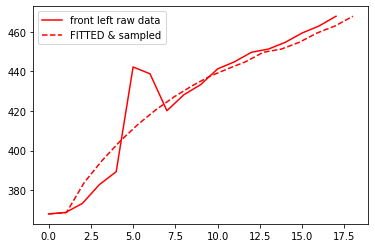

In [152]:
plt.plot(time, front_left['x'], color = 'red', label = 'front left raw data')
plt.plot(timedata, xdata, 'r--', label = 'FITTED & sampled')
plt.legend()
plt.savefig('test.png')

In [65]:
popt_x, pcov_x = curve_fit(polynomial, timedata, xdata, sigma = stderr)


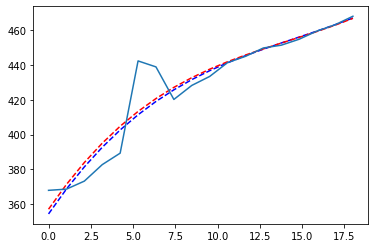

In [71]:
plt.plot(timedata, polynomial(timedata, *popt_x), 'b--')
plt.plot(timedata, polynomial(timedata, *popt_x_init), 'r--')
plt.plot(timedata, xdata)


TypeError: score() missing 2 required positional arguments: 'X' and 'y'

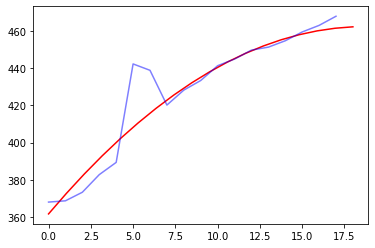

In [33]:
plt.plot(timedata, polynomial(timedata, reg.intercept_ ,reg.coef_[0],reg.coef_[1], 0), color = 'red')
plt.plot(time, front_left['x'], color = 'blue', label = 'front left x', alpha = .5)


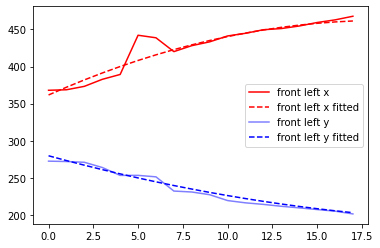

In [115]:
plt.plot(time, front_left['x'], color = 'red', label = 'front left x')
plt.plot(time, polynomial(time, popt_x[0], popt_x[1], popt_x[2]), 'r--', label = 'front left x fitted')
plt.plot(time, front_left['y'], color = 'blue', label = 'front left y', alpha = .5)
plt.plot(time, polynomial(time, popt_y[0], popt_y[1], popt_y[2]), 'b--', label = 'front left y fitted')
plt.legend()

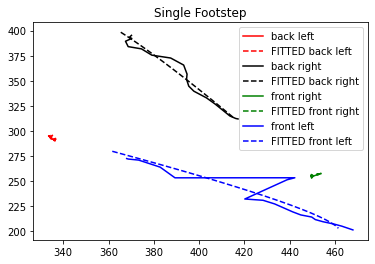

In [127]:
plt.plot(back_left['x'], back_left['y'], color = 'red', label = 'back left')
fitted_x, fitted_y = fit_paw_to_polynomial(back_left)
plt.plot(fitted_x, fitted_y, 'r--', label = 'FITTED back left')
plt.plot(back_right['x'], back_right['y'], color = 'black', label = 'back right')
fitted_x, fitted_y = fit_paw_to_polynomial(back_right)
plt.plot(fitted_x, fitted_y, 'k--', label = 'FITTED back right')
plt.plot(front_right['x'], front_right['y'], color = 'green', label = 'front right')
fitted_x, fitted_y = fit_paw_to_polynomial(front_right)
plt.plot(fitted_x, fitted_y, 'g--', label = 'FITTED front right')
plt.plot(front_left['x'], front_left['y'], color = 'blue', label = 'front left')
plt.plot(polynomial(time, popt_x[0], popt_x[1], popt_x[2]), polynomial(time, popt_y[0], popt_y[1], popt_y[2]), 'b--', label = 'FITTED front left')
plt.title('Single Footstep')
plt.legend()
plt.savefig('fitpoly.png')
plt.show()